<a href="https://colab.research.google.com/github/ibenatar-96/statistical-rethinking-numpyro/blob/main/chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q numpyro arviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 4.4 MB/s eta 0:00:00


### Chapter 2

In [6]:
import os

import arviz as az
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

In [3]:
# Code 2.2
jnp.exp(dist.Binomial(total_count=9, probs=0.5).log_prob(6)) # This calculates the PMF of Binomial dist with total count 9 and probability 0.5, and when we do log_prob(6) it returns the value that underlies in the entry 6.

Array(0.16406256, dtype=float32)

p_grid: [0.         0.05263158 0.10526316 0.15789473 0.21052632 0.2631579
 0.31578946 0.36842105 0.42105263 0.47368422 0.5263158  0.57894737
 0.6315789  0.68421054 0.7368421  0.7894737  0.84210527 0.8947368
 0.94736844 1.        ]
prior: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
likelihood: [0.00000000e+00 1.51814879e-06 8.18509870e-05 7.77292182e-04
 3.59857874e-03 1.11609558e-02 2.66829841e-02 5.29211238e-02
 9.08269733e-02 1.38341367e-01 1.89768642e-01 2.36114696e-01
 2.66611278e-01 2.71400630e-01 2.45005220e-01 1.89768553e-01
 1.17918134e-01 5.02667204e-02 8.85383226e-03 1.42301432e-19]
std_posterior: [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.2043391e-01 1.4984676e-01 1.6920097e-01 1.7224047e-01 1.5548901e-01
 1.2043386e-01 7.4835032e-02 3.1901043e-02 5.6189559e-03 9.0309537e-20]


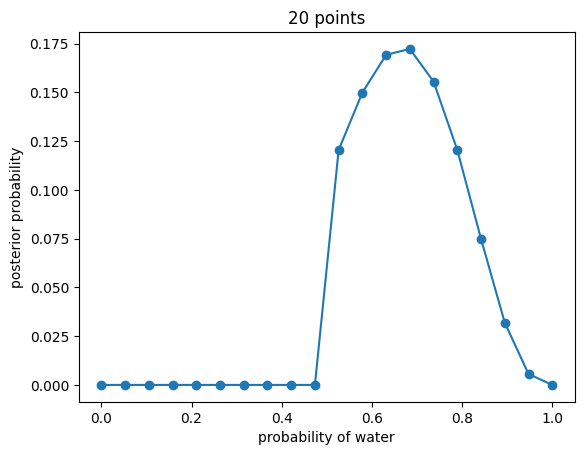

In [5]:
# Code 2.3

# define p_grid
p_grid = jnp.linspace(start=0, stop=1, num=20)
print(f"p_grid: {p_grid}")

# define prior
# prior = jnp.repeat(1, 20) # this is a "weak" prior, because we are basically saying that each value of p, has the same probability, when we can infact say that we know "for sure" that water is atleast 50% of the proportian.
prior = jnp.where(p_grid < 0.5, 0, 1)
print(f"prior: {prior}")

# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6)) # this is like saying, what is the distribution -- likelihood -- given that we have 9 trials, and 6 of them were success (6 is the observed data)
                                                                             # this is calculated for EVERY probability in p_grid.. meaning what is the probability of seeing 6 success in 9 trials when the p is 0,
                                                                             # then calculates, what is the probability of seeing 6 success in 9 trials when the p is equal to 0.05, and so on until p is equal to 1.
print(f"likelihood: {likelihood}")

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# normalize unstd_posterior
std_posterior = unstd_posterior / jnp.sum(unstd_posterior)
print(f"std_posterior: {std_posterior}")


# Code 2.4

plt.plot(p_grid, std_posterior, '-o')
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("20 points")
plt.show()

In [12]:
# Code 2.6

def model(W, L):
    p = numpyro.sample("p", dist.Uniform(0, 1))  # uniform prior
    numpyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), W=6, L=3)
svi_result = svi.run(random.PRNGKey(0), 1000)
params = svi_result.params

# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, sample_shape=(1000,))
numpyro.diagnostics.print_summary(samples, prob=0.89, group_by_chain=False)

100%|██████████| 1000/1000 [00:00<00:00, 2561.98it/s, init loss: 2.9278, avg. loss [951-1000]: 2.7795]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         p      0.62      0.14      0.63      0.41      0.84    845.27      1.00



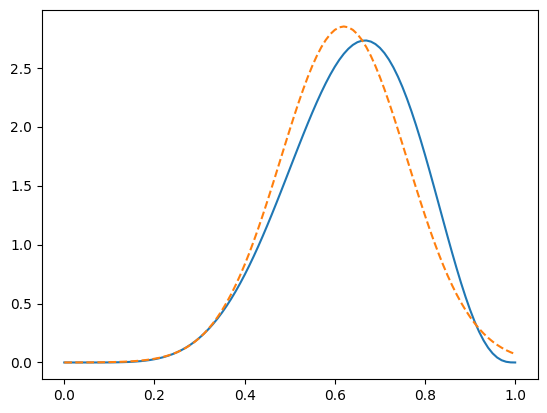

In [11]:
# Code 2.7

W = 6
L = 3
x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)))
# quadratic approximation
plt.plot(x, jnp.exp(dist.Normal(0.62, 0.14).log_prob(x)), "--") # 0.62 and 0.14 are the mean and std from the previous code section respectively.
plt.show()

In [15]:
# Code 2.8

n_samples = 1000
p = [jnp.nan] * n_samples
p[0] = 0.5
W = 6
L = 3
with numpyro.handlers.seed(rng_seed=0):
    for i in range(1, n_samples):
        p_new = numpyro.sample("p_new", dist.Normal(p[i - 1], 0.1))
        p_new = jnp.abs(p_new) if p_new < 0 else p_new
        p_new = 2 - p_new if p_new > 1 else p_new
        q0 = jnp.exp(dist.Binomial(W + L, p[i - 1]).log_prob(W))
        q1 = jnp.exp(dist.Binomial(W + L, p_new).log_prob(W))
        u = numpyro.sample("u", dist.Uniform())
        p[i] = p_new if u < q1 / q0 else p[i - 1]

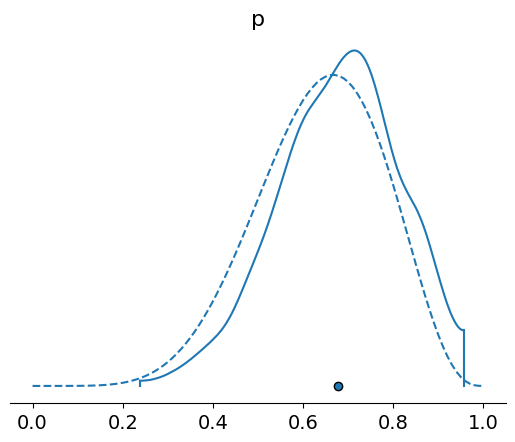

In [16]:
# Code 2.9

az.plot_density({"p": p}, hdi_prob=1)
plt.plot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)), "--")
plt.show()